In [1]:
import torch
import numpy as np
import scanpy as sc
import anndata

from src.models import scTransv2
from src.models.attn_trans import prediect

def pred_trans(query_adata):
    mask=np.load("/data0/tzc/SingleCell/scRNAseqCLS/result/pbmc10k/mask.npy")
    scmodel=scTransv2.scTrans_model(num_classes=19, num_genes=2000, mask=mask, embed_dim=48, depth=1, num_heads=2, has_logits=False)
    print("model created")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    scmodel.to(device=device)
    scmodel.load_state_dict(torch.load("/data0/tzc/SingleCell/scRNAseqCLS/result/pbmc10k/teacher_3.pth", 
                                     map_location=device
                                     ), 
                          strict=False
                          )
    print("param loaded")

    new, gene2token = prediect(query_adata, 
             scmodel, 
             laten=True, 
             pathway="/data0/tzc/SingleCell/scRNAseqCLS/result/pbmc10k/pathway.csv",
             diction="/data0/tzc/SingleCell/scRNAseqCLS/result/pbmc10k/label_dictionary.csv",
             save_att = 'X_att', 
             save_lantent = 'X_lat',
             n_step=10000,
             cutoff=0.1,
             n_unannotated = 1,
             batch_size = 50,
             embed_dim=48)

    return new, gene2token

cdc_adata = sc.read('/data0/tzc/SingleCell/scRNAseqCLS/dataset/pbmc10k/clean.h5ad')
new, gene2token = pred_trans(cdc_adata)

/home/tangzhenchao/anaconda3/envs/ATAC/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


model created
cuda
param loaded
0
9631


/home/tangzhenchao/anaconda3/envs/ATAC/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
new.write('/data0/tzc/SingleCell/scRNAseqCLS/result/pbmc10k/scTrans_attn.h5ad')
gene2token.to_csv('/data0/tzc/SingleCell/scRNAseqCLS/result/pbmc10k/gene2token_weights.csv')

In [4]:
query_adata = sc.read('/data0/tzc/SingleCell/scRNAseqCLS/dataset/pbmc10k/clean.h5ad')
attn_adata = sc.read('/data0/tzc/SingleCell/scRNAseqCLS/result/pbmc10k/scTrans_attn.h5ad')

attn_adata.obs['cell type'] = query_adata.obs['cell type']

In [5]:
attn_adata.obsm['X_emb'] = attn_adata.X
sc.pp.neighbors(attn_adata, n_neighbors=10, use_rep="X_emb", metric="cosine")
sc.tl.umap(attn_adata)

/home/tangzhenchao/anaconda3/envs/ATAC/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/tangzhenchao/anaconda3/envs/ATAC/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/tangzhenchao/anaconda3/envs/ATAC/lib/python3.8/site-packag

/home/tangzhenchao/anaconda3/envs/ATAC/lib/python3.8/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


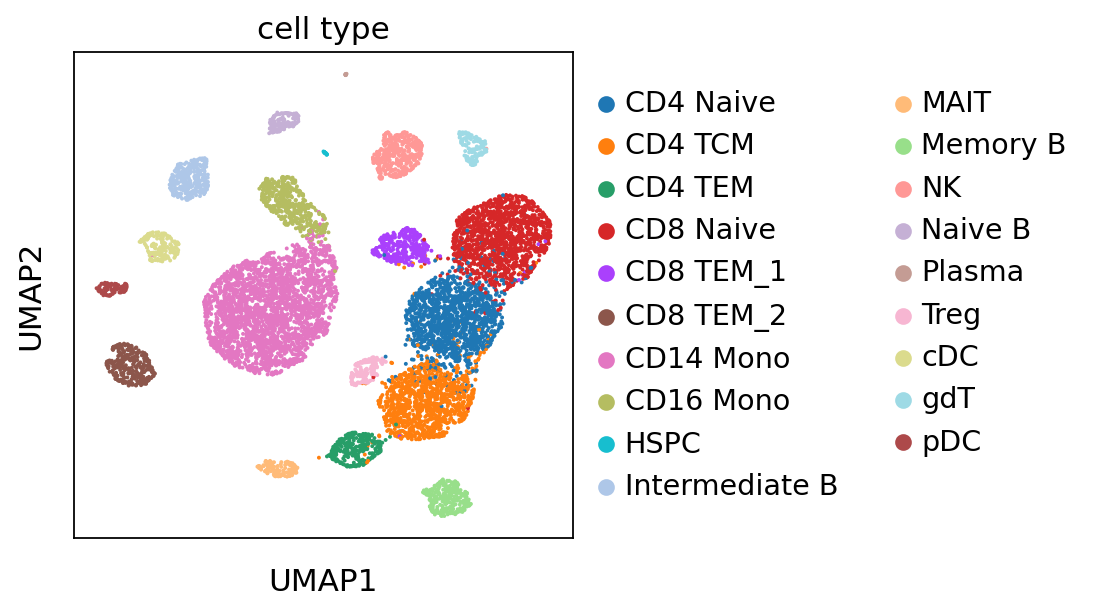

In [20]:
sc.set_figure_params(dpi=80)
sc.pl.umap(attn_adata, color=['cell type'])

In [16]:
from src.models.dataset import splitDataSet, MyDataSet, extract_data_for_pred
from src.models import scTrans, dataset, train_trans, MLPv2

def emb_mlp(adata, reduction="UMAP", metric='cosine'):
    '''
    metric: 'euclidean', 'cosine', 'dice'
    '''
    mlp = MLPv2.mlp_model(num_classes=19, num_genes=2000, embed_dim=[512, 256, 64])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mlp.to(device=device)
    mlp.load_state_dict(torch.load("/data0/tzc/SingleCell/scRNAseqCLS/result/pbmc10k/mlp_3.pth", 
                                       map_location=device
                                      ), 
                            strict=False
                            )
    print("mlp loaded")

    mat = extract_data_for_pred(adata)
    hidden, y_pred = mlp.predict(mat, device)
    X_emb = hidden
    print("prob shape: ", X_emb.shape)
    adata.obsm["X_emb"]=X_emb

    print("plot stage: ", reduction)
    if reduction == "UMAP":
        sc.pp.neighbors(adata, n_neighbors=10, use_rep="X_emb", metric=metric) 
        sc.tl.umap(adata)

query_adata = sc.read('/data0/tzc/SingleCell/scRNAseqCLS/dataset/pbmc10k/clean.h5ad')
emb_mlp(query_adata)

mlp loaded
prob shape:  (9631, 64)
plot stage:  UMAP


/home/tangzhenchao/anaconda3/envs/ATAC/lib/python3.8/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


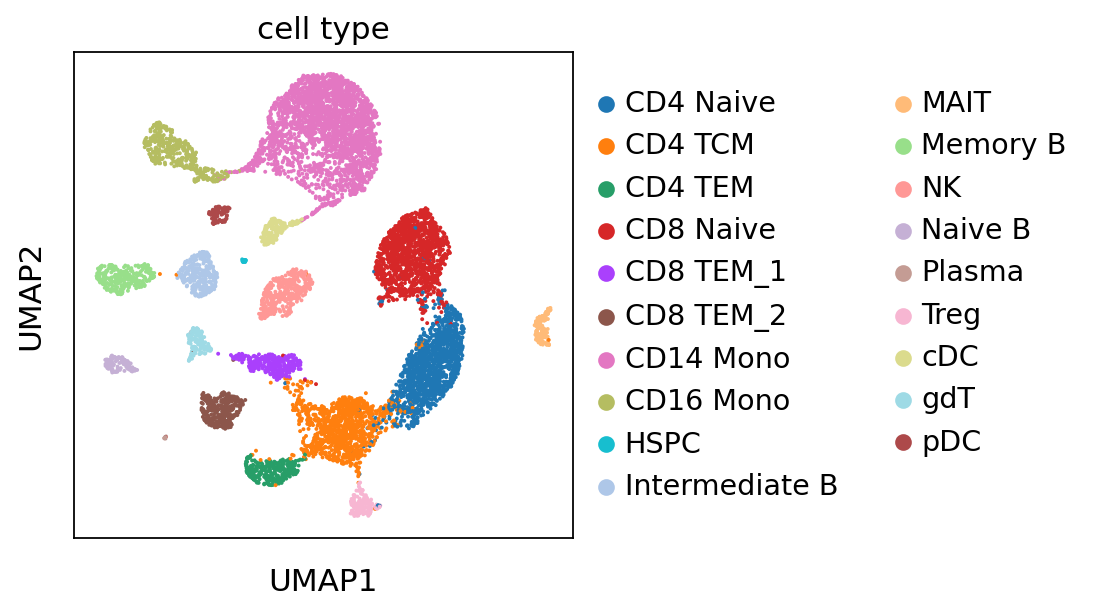

In [19]:
sc.set_figure_params(dpi=80)
sc.pl.umap(query_adata, color=['cell type'])